In [25]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd

file_path = '/content/drive/MyDrive/vodafone_data.csv'

df= pd.read_csv(file_path, delimiter=';')
print(df.head())

                                         Explanation  Target
0  Vodafone'a ıyy diyen hayatında hiç vodafone ku...       1
1  Her yerde çekiyor diye geçtiğim güne lanet ols...       0
2  Vodafone benim için bitti artık her yerde çeki...       0
3  Vodafone Sizin de içine mi sızdılar yoksa bili...       0
4  Saf olmamak gerekir. Güvenlik açığı demek olay...       0


In [27]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import classification_report
import unicodedata


In [28]:

def clean_turkish_text(text):
  if not isinstance(text, str):
        return ""  # or return text if you prefer to keep non-string values as is

    # Normalize Unicode characters (NFKC Normalization)
  text = unicodedata.normalize('NFKC', text)

    # Convert to lowercase
  text = text.lower()

    # Remove special characters, keep letters, numbers, and spaces
  text = re.sub(r'[^a-zA-Z0-9çğıöşü\s]', '', text)

    # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()


  return text

df['Cleaned_Explanation'] = df['Explanation'].apply(clean_turkish_text)

print(df.head())

                                         Explanation  Target  \
0  Vodafone'a ıyy diyen hayatında hiç vodafone ku...       1   
1  Her yerde çekiyor diye geçtiğim güne lanet ols...       0   
2  Vodafone benim için bitti artık her yerde çeki...       0   
3  Vodafone Sizin de içine mi sızdılar yoksa bili...       0   
4  Saf olmamak gerekir. Güvenlik açığı demek olay...       0   

                                 Cleaned_Explanation  
0  vodafonea ıyy diyen hayatında hiç vodafone kul...  
1  her yerde çekiyor diye geçtiğim güne lanet ols...  
2  vodafone benim için bitti artık her yerde çeki...  
3  vodafone sizin de içine mi sızdılar yoksa bili...  
4  saf olmamak gerekir güvenlik açığı demek olayı...  


In [29]:
X = df['Cleaned_Explanation']  # Features
y = df['Target']  # Labels

X_train_val, X_test, y_train_val, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

skf = StratifiedKFold(n_splits=5)

for train_index, val_index in skf.split(X_train_val, y_train_val):
    X_train_fold, X_val_fold = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train_fold, y_val_fold = y_train_val.iloc[train_index], y_train_val.iloc[val_index]



In [30]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')

max_len= 512
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(X_train_fold.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(X_val_fold.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

In [31]:
model = TFBertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-cased',num_labels=3)

# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
#Train the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	y_train_fold,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val_fold),
	batch_size=16,
	epochs=3
)

Epoch 1/3
194/194 [==============================] - 368s 2s/step - loss: 0.7569 - accuracy: 0.6588 - val_loss: 0.8052 - val_accuracy: 0.7180
Epoch 2/3
194/194 [==============================] - 326s 2s/step - loss: 0.5731 - accuracy: 0.7697 - val_loss: 0.5157 - val_accuracy: 0.8047
Epoch 3/3
194/194 [==============================] - 326s 2s/step - loss: 0.4042 - accuracy: 0.8480 - val_loss: 0.5189 - val_accuracy: 0.8305


In [33]:
pred = model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
	0: 'Negative',
	1: 'Positive',
  2: 'Neutral'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])


31/31 [==============================] - 31s 877ms/step
Predicted Label : ['Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Neutral', 'Negative', 'Positive', 'Positive', 'Positive']
Actual Label : ['Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Positive']


In [34]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.85      0.94      0.89       581
     Neutral       0.70      0.54      0.61       145
    Positive       0.81      0.70      0.75       241

    accuracy                           0.82       967
   macro avg       0.79      0.73      0.75       967
weighted avg       0.82      0.82      0.82       967



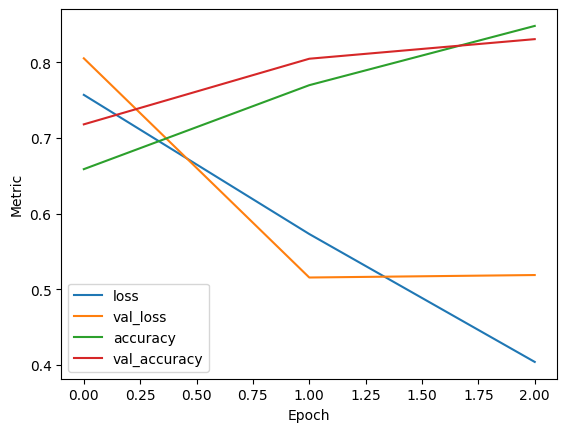

In [35]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [37]:
import os
# Define the path where you want to save the model
model_save_path = '/content/drive/MyDrive/bert_model2/'

# Create the directory if it does not exist
os.makedirs(model_save_path, exist_ok=True)

# Save the model
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")

Model and tokenizer saved to /content/drive/MyDrive/bert_model2/


In [38]:
# Define a function to predict the sentiment of a single input text
def predict_sentiment(text):
    # Clean the text
    cleaned_text = clean_turkish_text(text)

    # Tokenize and encode the text
    encoded_input = tokenizer.encode_plus(
        cleaned_text,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='tf'
    )

    # Make a prediction
    pred = model.predict([encoded_input['input_ids'], encoded_input['token_type_ids'], encoded_input['attention_mask']])

    # Get the logits
    logits = pred.logits

    # Get the predicted label index (use argmax to get the index of the highest score)
    pred_label_index = tf.argmax(logits, axis=1).numpy()[0]

    # Convert the label index to a string label
    pred_label = label[pred_label_index]

    return pred_label




In [39]:
input_text = "Bu ürün gerçekten harika, çok memnun kaldım!"
predicted_sentiment = predict_sentiment(input_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 [==============================] - 5s 5s/step
Predicted Sentiment: Positive


In [40]:
input_text = "Vodafone pişmanlıktır bir daha asla"
predicted_sentiment = predict_sentiment(input_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 [==============================] - 0s 118ms/step
Predicted Sentiment: Negative


In [42]:
input_text = "idare eder işimi görüyor şimdilik"
predicted_sentiment = predict_sentiment(input_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 [==============================] - 0s 121ms/step
Predicted Sentiment: Neutral
